In [1]:
import os
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
import itertools as it
from sklearn.feature_selection import RFE
import matplotlib.gridspec as gridspec

sns.set_style("whitegrid")

# set project dir
from project_utils.envtools import set_project_dir
set_project_dir()

# set output dir
outdir = 'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/'
os.makedirs(outdir, exist_ok=True)

# set the random_state
random_state = 17

## Load the data

In [2]:
# Load the protein levels data
protein_data = pd.read_csv("results/specimen_focused/comp_data/protein_levels.250_prots.npq.tsv", sep="\t")
protein_data = protein_data.T

# extract triplet
protein_data = protein_data.loc[:,:]

# Load the clinical data
clinical_data = pd.read_csv("results/specimen_focused/comp_data/clinical_data.tsv", sep="\t")

# remove alamar samples
keep = (~clinical_data['sample_id'].str.contains('SC_Rep')).tolist()
clinical_data = clinical_data.loc[keep,:]
protein_data = protein_data.loc[keep,:]

# extract just CD and UC data
focus_idxs = np.argwhere(clinical_data['ibd_diagnosis'].isin(['CD', 'UC'])).reshape(-1)

# commented out on purpose, need all samples 
clinical_data = clinical_data.iloc[focus_idxs]
protein_data = protein_data.iloc[focus_idxs]

In [3]:
protein_data.head()

,AGER,AGRP,ANGPT1,ANGPT2,ANXA1,AREG,BDNF,BMP7,BST2,C1QA,...,TREM2,TSLP,VCAM1,VEGFA,VEGFC,VEGFD,VSNL1,VSTM1,WNT16,WNT7A
TRP-34082,5.493463,8.765074,15.76212,11.250206,17.79754,14.68076,0.000000,7.512066,10.206268,8.081331,...,6.206720,10.94101,0.000000,18.23954,16.68403,9.214276,22.58694,14.75831,7.103437,8.497241
TRP-34086,4.453723,10.299592,17.59438,11.835780,16.49940,14.91346,9.248813,9.961362,11.179836,8.589964,...,0.000000,11.29018,7.094106,18.36369,19.17019,8.799946,20.19290,17.99542,7.941584,8.232622
TRP-42335,6.469100,11.617355,17.49572,12.059989,20.11341,12.85620,0.000000,8.614946,9.096235,9.529024,...,6.516471,11.47073,0.000000,18.52676,18.22880,7.187657,20.12907,17.56549,5.531130,5.503245
TRP-42324,5.398481,8.084902,18.85520,11.783576,20.28382,13.00942,0.000000,8.196127,10.835604,0.000000,...,5.131593,11.29977,0.000000,18.23974,17.62960,8.247575,20.06370,17.24266,0.000000,8.372645
TRP-42322,5.444545,9.068033,18.69799,12.531015,19.71289,16.21479,0.000000,9.476020,16.270733,10.781654,...,7.467110,11.17309,0.000000,18.78044,18.04191,11.034922,21.84698,17.57186,8.126035,9.796662


### load the post visit 1

In [4]:
cols = ['sample_id', 'matched_subject_id', 'ibd_diagnosis', 'event_name', 'cd_versus_uc_preds',
        'cd_versus_uc_probs', 'cd_given_data_probs', 'cd_given_data_logodds']

nv1_fn = 'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/nv1_predictions.xlsx'
nv1_clinical_data = pd.read_excel(nv1_fn)
nv1_clinical_data_sub = nv1_clinical_data[cols]

### load the visit 1

In [5]:
# get rep subjects from nv1 and filter
rep_subjects = nv1_clinical_data_sub.matched_subject_id.unique().tolist()
v1_fn = 'results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/v1_predictions.xlsx'
v1_clinical_data = pd.read_excel(v1_fn)
v1_clinical_data = v1_clinical_data[cols]
v1_clinical_data = v1_clinical_data.loc[v1_clinical_data.matched_subject_id.isin(rep_subjects),:]

In [6]:
rep_clinical_data = pd.concat([v1_clinical_data, nv1_clinical_data_sub])
rep_clinical_data['IBD Prediction'] = rep_clinical_data['cd_given_data_probs'].apply(lambda x: 'CD' if x >= 0.5 else 'UC')

In [7]:
rep_clinical_data.loc[:, 'Visit Dichotomy'] =  rep_clinical_data.event_name.apply(lambda x: 'V1' if x == 1 else 'PV1')

### load top 14 features

In [22]:
select_n = 14

# load the model results
fn = os.path.join(outdir, f'logit_model.rfe_{select_n}_proteins.coefs.xlsx')
logit_model_coefs = pd.read_excel(fn)
selected_features_list = logit_model_coefs.protein.tolist()

In [23]:
selected_features_list

['IL34',
 'IL17RA',
 'TNFSF11',
 'CD40LG',
 'IFNA1; IFNA13',
 'SPP1',
 'CD93',
 'IL12p70',
 'GZMA',
 'IL1R2',
 'ICOSLG',
 'CCL1',
 'GFAP',
 'GDF2']

# Locate the replicates

In [8]:
duplicated_subjects = clinical_data.matched_subject_id.value_counts()
duplicated_subjects = duplicated_subjects.loc[duplicated_subjects > 1]

In [9]:
duplicated_subjects.to_frame()

,count
matched_subject_id,
9.0,4
16.0,3
4.0,3
13.0,3
31.0,3
42.0,3
28.0,3
8.0,2
21.0,2


In [10]:
clinical_dup_data = clinical_data.loc[clinical_data.matched_subject_id.isin(duplicated_subjects.index.tolist()),:]
clinical_dup_data = clinical_dup_data.sort_values(['ibd_diagnosis', 'matched_subject_id', 'event_name'])

### Correlate replicate samples to one another using ALL proteins

In [11]:
subject_corrs = protein_data.loc[clinical_dup_data.sample_id.tolist(),:].transpose().corr()

In [12]:
subject_visit_no = pd.DataFrame(subject_corrs.index.tolist())
subject_visit_no = subject_visit_no.merge(clinical_dup_data, left_on=0, right_on='sample_id')
subject_visit_no = subject_visit_no.event_name.apply(lambda x: f'Visit {x:.0f}')

In [13]:
# create a new version that only visualizes the pairs we want
subject_corrs_prime = pd.DataFrame(np.zeros(subject_corrs.shape))
subject_corrs_prime.index = subject_corrs.index.tolist()
subject_corrs_prime.columns = subject_corrs.index.tolist()

for grp, grp_df in clinical_dup_data.groupby('matched_subject_id'):

    curr_list = grp_df.sample_id.tolist()
    pairs = list(it.product(curr_list, curr_list))
    for p1, p2 in pairs:

        # update the main and reverse pair
        subject_corrs_prime.loc[p1, p2] = subject_corrs.loc[p1, p2]
        subject_corrs_prime.loc[p2, p1] = subject_corrs.loc[p2, p1]

In [14]:
# --------------------------
# Step A: Mask zeros
# --------------------------
# Create a mask where values are zero
mask = subject_corrs_prime == 0

In [15]:
# Get the default colormap you want to use
base_cmap = sns.color_palette("YlOrBr", as_cmap=True)

# Set the color for masked values (e.g., white or lightgray)
base_cmap.set_bad(color='white')  # or 'lightgray'

Text(0.5, 102.72222222222233, '')

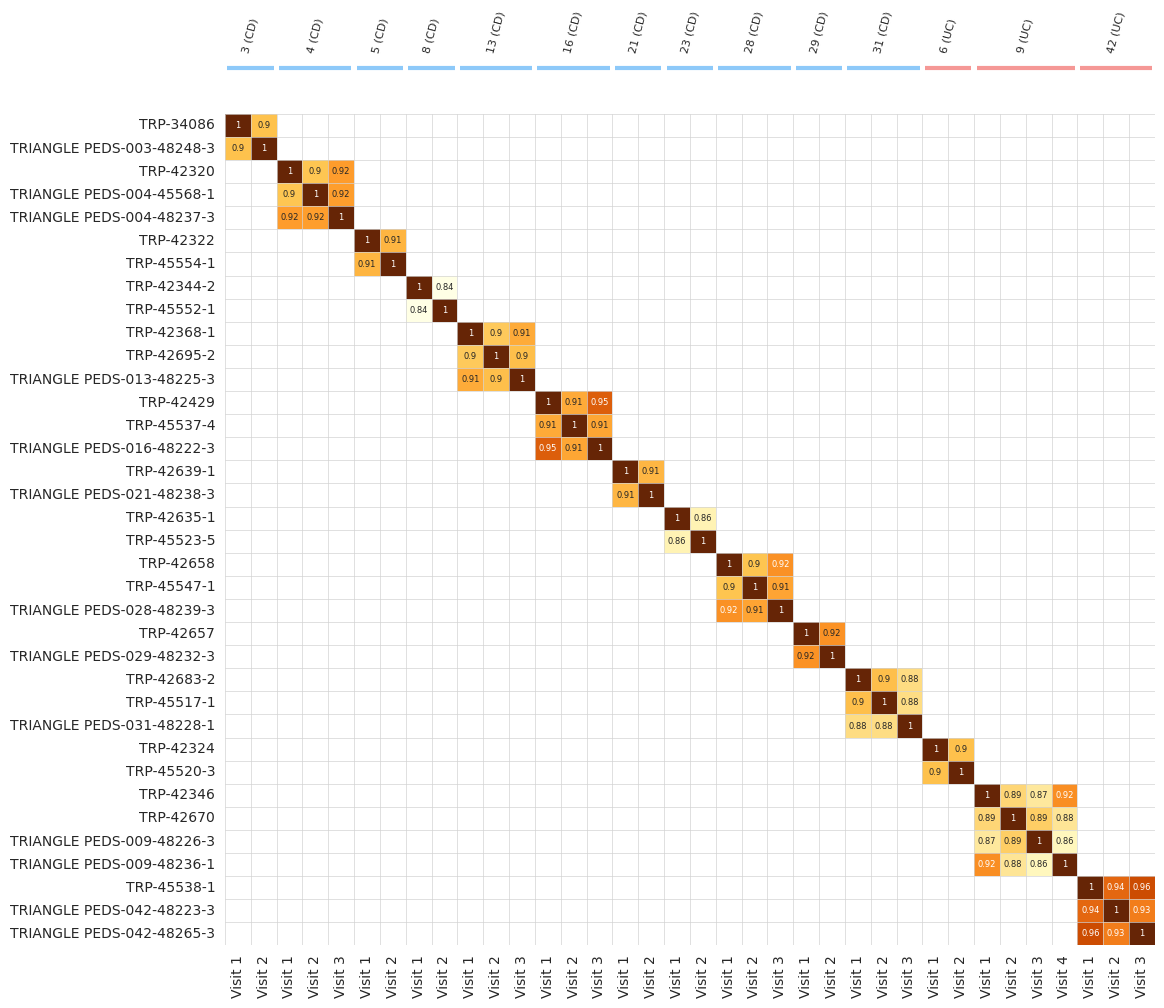

In [21]:
color_palette = {
    "solid_red": "#C62828",
    "light_red": "#EF5350",
    "solid_blue": "#1565C0",
    "light_blue": "#42A5F5"
}

# Sample dataframe assumption
# nv1_clinical_data_sub has: sample_id, cd_versus_uc_probs, patient_id
rep_clinical_data = rep_clinical_data.reset_index(drop=True)
rep_clinical_data.sort_values(['ibd_diagnosis', 'matched_subject_id', 'event_name'], inplace=True)

sample_ids = rep_clinical_data.apply(lambda x: f'{x.sample_id} (Visit {x.event_name})', axis=1)
sample_ids = rep_clinical_data.apply(lambda x: f'Visit {x.event_name}', axis=1)
patient_ids = rep_clinical_data['matched_subject_id'].tolist()
x_positions = list(range(len(sample_ids)))  # Numeric x for shared axis

# Set up GridSpec
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 9], hspace=0, wspace=0)

# Top axis for patient grouping
ax_top = fig.add_subplot(gs[0])
ax_top.set_xlim(-0.5, len(sample_ids) - 0.5)
ax_top.set_ylim(0, 1)
ax_top.axis('off')

# Draw patient group bars
groupings = []
current_patient = patient_ids[0]
start = 0
for i in range(1, len(patient_ids)):
    if patient_ids[i] != current_patient:
        groupings.append((start, i - 1, current_patient))
        current_patient = patient_ids[i]
        start = i
groupings.append((start, len(patient_ids) - 1, current_patient))  # last group

rep_clinical_data_tmp = rep_clinical_data.drop_duplicates('matched_subject_id').set_index('matched_subject_id')
bars_palette = {'CD': color_palette['light_blue'], 'UC': color_palette['light_red']}
for start, end, matched_subject_id in groupings:

    true_ibd = rep_clinical_data_tmp.loc[matched_subject_id]['ibd_diagnosis']
    annot = f'{matched_subject_id} ({true_ibd})'
    
    ax_top.hlines(y=0.5, xmin=start + 0.1, xmax=end + 0.9, colors=bars_palette[true_ibd], linewidth=3, alpha=0.6)
    ax_top.text((start + end) / 2 + 0.5, 0.65, annot, ha='center', va='bottom', fontsize=8, rotation=75)


# Bottom axis for main heatmap

# Get number of samples
n = subject_corrs.shape[0]

ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)  # share x
ax_bottom.set_xlim(-0.5, len(sample_ids) - 0.5)

subject_corrs_prime_temp = subject_corrs_prime.copy()
subject_corrs_prime_temp.columns = subject_visit_no
mask = subject_corrs_prime_temp == 0
sns.heatmap(
    subject_corrs_prime_temp,
    cmap=base_cmap,
    mask=mask,
    annot=True,
    cbar=False,
    annot_kws={'fontsize': 6},
    ax=ax_bottom
)

# Draw horizontal and vertical lines
for i in range(n + 1):
    ax_bottom.axhline(i, color='#D3D3D3', linewidth=0.5)
    ax_bottom.axvline(i, color='#D3D3D3', linewidth=0.5)

ax_bottom.set_xlabel('')

### Correlate samples to one another using Top RFE variables

In [29]:
subject_corrs = protein_data.loc[clinical_dup_data.sample_id.tolist(),selected_features_list].transpose().corr()

In [30]:
subject_visit_no = pd.DataFrame(subject_corrs.index.tolist())
subject_visit_no = subject_visit_no.merge(clinical_dup_data, left_on=0, right_on='sample_id')
subject_visit_no = subject_visit_no.event_name.apply(lambda x: f'Visit {x:.0f}')

In [31]:
# create a new version that only visualizes the pairs we want
subject_corrs_prime = pd.DataFrame(np.zeros(subject_corrs.shape))
subject_corrs_prime.index = subject_corrs.index.tolist()
subject_corrs_prime.columns = subject_corrs.index.tolist()

for grp, grp_df in clinical_dup_data.groupby('matched_subject_id'):

    curr_list = grp_df.sample_id.tolist()
    pairs = list(it.product(curr_list, curr_list))
    for p1, p2 in pairs:

        # update the main and reverse pair
        subject_corrs_prime.loc[p1, p2] = subject_corrs.loc[p1, p2]
        subject_corrs_prime.loc[p2, p1] = subject_corrs.loc[p2, p1]

In [32]:
# --------------------------
# Step A: Mask zeros
# --------------------------
# Create a mask where values are zero
mask = subject_corrs_prime == 0

/global/home/reynaj/.conda/envs/py-starter/lib/python3.1/site-packages/seaborn/utils.py:61: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()


Text(0.5, 102.72222222222233, '')

/global/home/reynaj/.conda/envs/py-starter/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/global/home/reynaj/.conda/envs/py-starter/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


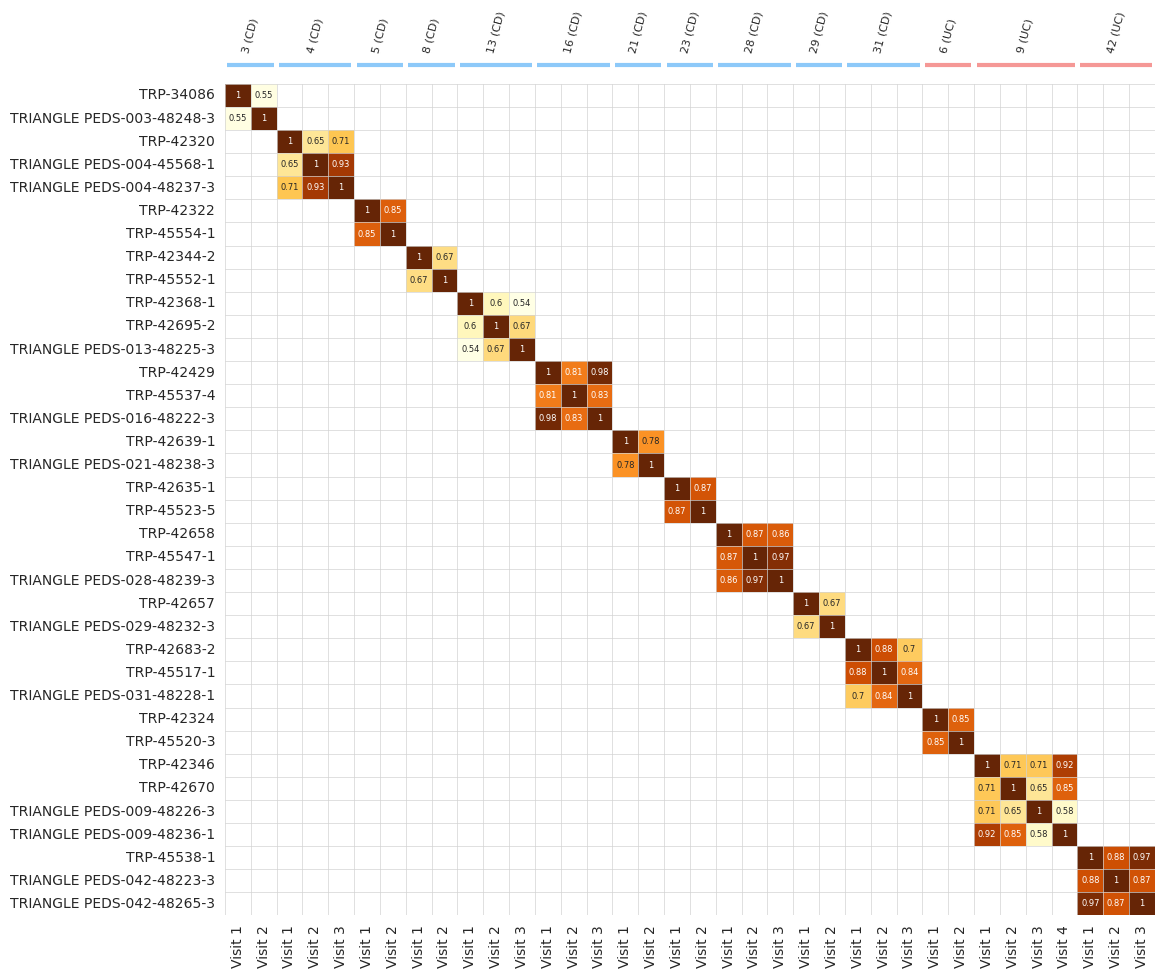

In [38]:
# Set up GridSpec
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 9], hspace=0, wspace=0)

# Top axis for patient grouping
ax_top = fig.add_subplot(gs[0])
ax_top.set_xlim(-0.5, len(sample_ids) - 0.5)
ax_top.set_ylim(0, 1)
ax_top.axis('off')

box = ax_top.get_position()
ax_top.set_position([box.x0, box.y0 - 0.015, box.width, box.height * 0.8])

# Draw patient group bars
groupings = []
current_patient = patient_ids[0]
start = 0
for i in range(1, len(patient_ids)):
    if patient_ids[i] != current_patient:
        groupings.append((start, i - 1, current_patient))
        current_patient = patient_ids[i]
        start = i
groupings.append((start, len(patient_ids) - 1, current_patient))  # last group

rep_clinical_data_tmp = rep_clinical_data.drop_duplicates('matched_subject_id').set_index('matched_subject_id')
bars_palette = {'CD': color_palette['light_blue'], 'UC': color_palette['light_red']}
for start, end, matched_subject_id in groupings:

    true_ibd = rep_clinical_data_tmp.loc[matched_subject_id]['ibd_diagnosis']
    annot = f'{matched_subject_id} ({true_ibd})'
    
    ax_top.hlines(y=0.5, xmin=start + 0.1, xmax=end + 0.9, colors=bars_palette[true_ibd], linewidth=3, alpha=0.6)
    ax_top.text((start + end) / 2 + 0.5, 0.65, annot, ha='center', va='bottom', fontsize=8, rotation=75)


# Bottom axis for main heatmap

# Get number of samples
n = subject_corrs.shape[0]

ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)  # share x
ax_bottom.set_xlim(-0.5, len(sample_ids) - 0.5)

subject_corrs_prime_temp = subject_corrs_prime.copy()
subject_corrs_prime_temp.columns = subject_visit_no
mask = subject_corrs_prime_temp == 0
sns.heatmap(
    subject_corrs_prime_temp,
    cmap=base_cmap,
    mask=mask,
    annot=True,
    cbar=False,
    annot_kws={'fontsize': 6},
    ax=ax_bottom
)

# Draw horizontal and vertical lines
for i in range(n + 1):
    ax_bottom.axhline(i, color='#D3D3D3', linewidth=0.5)
    ax_bottom.axvline(i, color='#D3D3D3', linewidth=0.5)

ax_bottom.set_xlabel('')

# plt.tight_layout(pad=0)


## Plot Probabilities

### Plot the log odds for each Non-visit1 samples

/tmp/ipykernel_1602508/2976993909.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


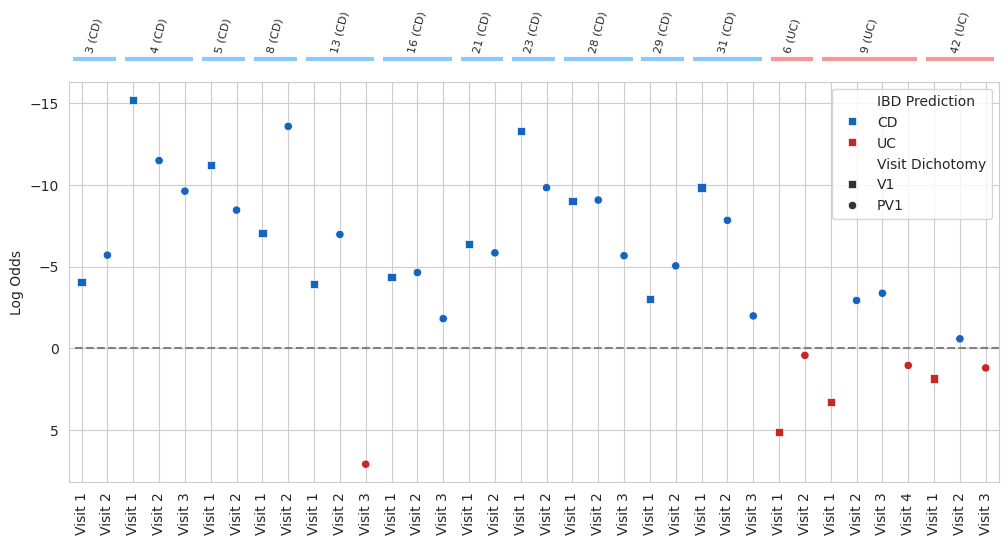

In [42]:
color_palette = {
    "solid_red": "#C62828",
    "light_red": "#EF5350",
    "solid_blue": "#1565C0",
    "light_blue": "#42A5F5"
}

# Sample dataframe assumption
# nv1_clinical_data_sub has: sample_id, cd_versus_uc_probs, patient_id
rep_clinical_data = rep_clinical_data.reset_index(drop=True)
rep_clinical_data.sort_values(['ibd_diagnosis', 'matched_subject_id', 'event_name'], inplace=True)

sample_ids = rep_clinical_data.apply(lambda x: f'{x.sample_id} (Visit {x.event_name})', axis=1)
sample_ids = rep_clinical_data.apply(lambda x: f'Visit {x.event_name}', axis=1)
patient_ids = rep_clinical_data['matched_subject_id'].tolist()
x_positions = list(range(len(sample_ids)))  # Numeric x for shared axis

# Set up GridSpec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 8], hspace=0.05)

# Top axis for patient grouping
ax_top = fig.add_subplot(gs[0])
ax_top.set_xlim(-0.5, len(sample_ids) - 0.5)
ax_top.set_ylim(0, 1)
ax_top.axis('off')

box = ax_top.get_position()
ax_top.set_position([box.x0, box.y0 - 0.015, box.width, box.height * 0.8])

# Draw patient group bars
groupings = []
current_patient = patient_ids[0]
start = 0
for i in range(1, len(patient_ids)):
    if patient_ids[i] != current_patient:
        groupings.append((start, i - 1, current_patient))
        current_patient = patient_ids[i]
        start = i
groupings.append((start, len(patient_ids) - 1, current_patient))  # last group

rep_clinical_data_tmp = rep_clinical_data.drop_duplicates('matched_subject_id').set_index('matched_subject_id')
bars_palette = {'CD': color_palette['light_blue'], 'UC': color_palette['light_red']}
for start, end, matched_subject_id in groupings:

    true_ibd = rep_clinical_data_tmp.loc[matched_subject_id]['ibd_diagnosis']
    annot = f'{matched_subject_id} ({true_ibd})'
    
    ax_top.hlines(y=0.5, xmin=start-0.33, xmax=end+0.33, colors=bars_palette[true_ibd], linewidth=3, alpha=0.6)
    ax_top.text((start + end) / 2, 0.65, annot, ha='center', va='bottom', fontsize=8, rotation=75)

# Bottom axis for main barplot
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)  # share x
dots_palette = {'CD': color_palette['solid_blue'], 'UC': color_palette['solid_red']}
sns.scatterplot(x=x_positions,
            y=rep_clinical_data['cd_given_data_logodds'],
            hue=rep_clinical_data['IBD Prediction'],
            style=rep_clinical_data['Visit Dichotomy'],
            markers={'V1': 's', 'PV1': 'o'},
            palette=dots_palette,
            ax=ax_bottom)

# Set xtick labels manually
ax_bottom.set_xticks(x_positions)
ax_bottom.set_xticklabels(sample_ids, rotation=90) # ha='right', va='top')
ax_bottom.set_xlabel('')
ax_bottom.set_ylabel('Log Odds')
ax_bottom.invert_yaxis()  # <--- this line reverses the y-axis

ax_bottom.hlines([0], xmin=-0.25, xmax=len(sample_ids) - 0.25, colors='grey', linestyles='--')

plt.tight_layout()
plt.show()


dot_fn = os.path.join(outdir, 'dot.svg')
fig.savefig(dot_fn)

In [43]:
os.path.abspath(dot_fn)

'/global/home/reynaj/Projects/kevin_byrd/20241011.kevin_byrd.ibd_nulisa/results/specimen_focused/logit_model/cd_versus_uc_only/visit_incorporated/dot.svg'